# Topic Modelling Notebook

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from bertopic import BERTopic
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
from sklearn.metrics import davies_bouldin_score



c:\Users\admin\Desktop\repos\DSA4213_Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import pandas as pd

# Load the file
path_train = r"..\embeddings_output\general_train_broad_embeddings.npz" # path to npz file
data_train = np.load(path_train, allow_pickle=True)
path_test = r"..\embeddings_output\general_test_broad_embeddings.npz" # path to npz file
data_test = np.load(path_test, allow_pickle=True)

print({k: data_train[k].shape for k in data_train.files})

embeddings_train = pd.DataFrame(data_train["embeddings"])
embeddings_train.columns = [f"emb_{i}" for i in range(embeddings_train.shape[1])]  # rename nicely
embeddings_train["text"] = data_train["texts"]
embeddings_train["label"] = data_train["labels"]

embeddings_test = pd.DataFrame(data_test["embeddings"])
embeddings_test.columns = [f"emb_{i}" for i in range(embeddings_test.shape[1])]  # rename nicely
embeddings_test["text"] = data_test["texts"]
embeddings_test["label"] = data_test["labels"]

print(embeddings_train.shape)
print(embeddings_train.head())

print(embeddings_test.shape)
print(embeddings_test.head())


{'embeddings': (11200, 384), 'texts': (11200,), 'labels': (11200,)}
(11200, 386)
      emb_0     emb_1     emb_2     emb_3     emb_4     emb_5     emb_6  \
0 -0.065954  0.129986 -0.027290  0.022978 -0.060881  0.020858 -0.097683   
1 -0.002380  0.061337  0.029013  0.004403 -0.013388 -0.011926 -0.017382   
2 -0.020936  0.029716  0.003486  0.019713 -0.003231  0.021080 -0.052675   
3 -0.100052  0.001816 -0.010476 -0.046205  0.034331 -0.054387  0.107253   
4 -0.011559 -0.028765  0.057984  0.075947  0.047227 -0.019874  0.011059   

      emb_7     emb_8     emb_9  ...   emb_376   emb_377   emb_378   emb_379  \
0  0.023718 -0.103246 -0.029989  ... -0.049650 -0.002975  0.014075 -0.105049   
1  0.044410 -0.059244 -0.088396  ... -0.055617  0.069392  0.007593  0.106782   
2  0.079947 -0.039729  0.032833  ... -0.047487  0.079180 -0.075348  0.085130   
3  0.026428  0.038723 -0.113006  ... -0.057479  0.006368 -0.001778  0.022304   
4  0.044840 -0.066399 -0.011631  ... -0.051420 -0.055166  0.038959  

In [3]:
texts = data_train["texts"]
labels = data_train["labels"]
emb_matrix = data_train["embeddings"]  # shape: (11200, 384)

train_df = pd.DataFrame({
    "text": texts,
    "label": labels,
    "embeddings": [vec.tolist() for vec in emb_matrix]
})

texts = data_test["texts"]
labels = data_test["labels"]
emb_matrix = data_test["embeddings"]  # shape: (11200, 384)

test_df = pd.DataFrame({
    "text": texts,
    "label": labels,
    "embeddings": [vec.tolist() for vec in emb_matrix]
})
print(train_df.shape, test_df.shape)

(11200, 3) (7430, 3)


In [4]:
train_df

,text,label,embeddings
0,i was wondering if anyone out there could enli...,3,"[-0.06595444679260254, 0.1299862563610077, -0...."
1,a fair number of brave souls who upgraded thei...,1,"[-0.0023795461747795343, 0.06133738532662392, ..."
2,well folks my mac plus finally gave up the gho...,1,"[-0.02093559131026268, 0.029716169461607933, 0..."
3,robert jc kyanko wrote do you have weiteks add...,1,"[-0.10005176812410355, 0.001815571915358305, -..."
4,from article by tom a baker my understanding i...,2,"[-0.011558875441551208, -0.028764866292476654,..."
...,...,...,...
11195,dn from david nye dn a neurology dn consultati...,2,"[-0.08230956643819809, -0.004875397775322199, ..."
11196,i have a very old mac 512k and a mac plus both...,1,"[0.03424369543790817, -0.01240040734410286, 0...."
11197,i just installed a dx266 cpu in a clone mother...,1,"[-0.02444908767938614, -0.014120932668447495, ..."
11198,in article edward bolson writes wouldnt this r...,1,"[0.04212794825434685, -0.06897043436765671, -0..."


# Topic Modeling 

## Init topic model

In [5]:
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
SEED = 42
from bertopic import BERTopic

# custom words to ignore
CUSTOM_STOPWORDS = []

# Pass your own preprocessor to remove them
def custom_preprocessor(text):
    text = text.lower()
    for w in CUSTOM_STOPWORDS:
        text = text.replace(w, " ")  # simple remove
    return text

umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

print("BERTopic parameters besides vectorizer_model initialized")

BERTopic parameters besides vectorizer_model initialized


## Vectorizer_model tuning

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from itertools import product
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

docs = embeddings_train["text"].tolist()
embeddings = embeddings_train[[f"emb_{i}" for i in range(embeddings_train.shape[1]-2)]].to_numpy()

param_grid = {
    "ngram_range": [(1, 1), (1, 2)],
    "min_df": [1, 5],
    "max_df": [1.0, 0.95],
}

tokenized_docs = [doc.split() for doc in docs]
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

keys, values = zip(*param_grid.items())
for combo in product(*values):
    params = dict(zip(keys, combo))
    print("Testing params:", params)

    vectorizer_model = CountVectorizer(
        stop_words="english",
        preprocessor=custom_preprocessor,
        **params
    )

    topic_model = BERTopic(
        embedding_model=None,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        low_memory=True,
        calculate_probabilities=False, # Set to False, not needed for coherence
        verbose=False,
        nr_topics=20,
    )
    topics, probs = topic_model.fit_transform(docs, embeddings)

    #Evaluation  (Topic Coherence)
    topics_dict = topic_model.get_topics()
    topic_words = [
        [word for word, _ in topics_dict[topic][:10]] 
        for topic in topics_dict if topic != -1
    ]
    coherence_model = CoherenceModel(
        topics=topic_words, 
        texts=tokenized_docs, 
        dictionary=dictionary, 
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()

    print(f"Topic Coherence: {coherence_score}")

In [6]:
best_params = {
    "ngram_range": (1, 2),
    "min_df": 1,
    "max_df": 1.0
}

vectorizer_model = CountVectorizer(
    stop_words="english",
    preprocessor=custom_preprocessor,
    **best_params
)

topic_model = BERTopic(
    embedding_model=None,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    low_memory=True,
    calculate_probabilities=True,  # Set to True if you want topic probabilities
    verbose=True,
    nr_topics=20,
)

In [7]:
docs = embeddings_train["text"].tolist()
embeddings_train = embeddings_train[[f"emb_{i}" for i in range(embeddings_train.shape[1]-2)]].to_numpy()

topics, probs = topic_model.fit_transform(docs, embeddings_train)
print("Unique topics (excl. -1 outliers):", sorted(t for t in set(topics) if t != -1))

2025-10-26 20:54:36,571 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-26 20:54:53,304 - BERTopic - Dimensionality - Completed ✓
2025-10-26 20:54:53,305 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-26 20:55:00,240 - BERTopic - Cluster - Completed ✓
2025-10-26 20:55:00,241 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-10-26 20:55:03,033 - BERTopic - Representation - Completed ✓
2025-10-26 20:55:03,038 - BERTopic - Topic reduction - Reducing number of topics
2025-10-26 20:55:03,058 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-26 20:55:06,005 - BERTopic - Representation - Completed ✓
2025-10-26 20:55:06,012 - BERTopic - Topic reduction - Reduced number of topics from 153 to 20


Unique topics (excl. -1 outliers): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [8]:
train_df["Topic"] = topics
train_df["Topic_Probability"] = [max(p) if p is not None else None for p in probs]
train_df

,text,label,embeddings,Topic,Topic_Probability
0,i was wondering if anyone out there could enli...,3,"[-0.06595444679260254, 0.1299862563610077, -0....",-1,0.116293
1,a fair number of brave souls who upgraded thei...,1,"[-0.0023795461747795343, 0.06133738532662392, ...",4,1.000000
2,well folks my mac plus finally gave up the gho...,1,"[-0.02093559131026268, 0.029716169461607933, 0...",7,0.221690
3,robert jc kyanko wrote do you have weiteks add...,1,"[-0.10005176812410355, 0.001815571915358305, -...",6,0.012177
4,from article by tom a baker my understanding i...,2,"[-0.011558875441551208, -0.028764866292476654,...",-1,0.104212
...,...,...,...,...,...
11195,dn from david nye dn a neurology dn consultati...,2,"[-0.08230956643819809, -0.004875397775322199, ...",-1,0.173305
11196,i have a very old mac 512k and a mac plus both...,1,"[0.03424369543790817, -0.01240040734410286, 0....",-1,0.183966
11197,i just installed a dx266 cpu in a clone mother...,1,"[-0.02444908767938614, -0.014120932668447495, ...",-1,0.133564
11198,in article edward bolson writes wouldnt this r...,1,"[0.04212794825434685, -0.06897043436765671, -0...",12,1.000000


In [9]:
topic_info = topic_model.get_topic_info()
topic_info.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4057,-1_writes_article_like_dont,"[writes, article, like, dont, just, use, know,...",[in article phill hallambaker writes horrors a...
1,0,1435,0_people_writes_dont_article,"[people, writes, dont, article, said, israel, ...",[the white house office of the press secretary...
2,1,1123,1_team_game_games_season,"[team, game, games, season, play, year, hockey...",[199293 los angeles kings notes and game repor...
3,2,610,2_god_jesus_people_believe,"[god, jesus, people, believe, think, writes, d...",[archivename atheismlogic altatheismarchivenam...
4,3,601,3_car_bike_writes_article,"[car, bike, writes, article, like, dod, just, ...",[my previous posting on dog attacks must have ...


In [10]:
topic_model.visualize_barchart()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.008032234625020099, 0.008231183075330967,
                    0.00835421105976224, 0.0084593324418795, 0.013326168952211564],
              'xaxis': 'x',
              'y': [said  , article  , dont  , writes  , people  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.009575039784337555, 0.009838286133965864,
                    0.010212615194733673, 0.013119915151959706,
                    0.014199207571332919],
              'xaxis': 'x2',
              'y': [play  , season  , games  , game  , team  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.00904988122640382, 0.009317440384141727,
                    0.010162162472612488, 0.011944940558063633,
                    0.018032140542085788],
              'xaxis': 'x3',
              'y': [think  , believe  , people  , jesus  , god  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.010105298003803945, 0.012078781829134362,
                    0.012942655069137264, 0.016715450070838193,
                    0.01945837742638433],
              'xaxis': 'x4',
              'y': [like  , article  , writes  , bike  , car  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.012719527520980106, 0.01505683783474112,
                    0.01612472830434143, 0.01842494140316911, 0.025288342201884355],
              'xaxis': 'x5',
              'y': [controller  , drives  , scsi  , card  , drive  ],
              'yaxis': 'y5'},
             {'marker': {'color': '#009E73'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.008022889530210056, 0.008176391804836529,
                    0.008270444792732383, 0.015945464478925146,
                    0.019642806106591637],
              'xaxis': 'x6',
              'y': [program  , use  , files  , windows  , file  ],
              'yaxis': 'y6'},
             {'marker': {'color': '#F0E442'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.010755523398885308, 0.011300725058737053,
                    0.012651343869787895, 0.016854651969416594,
                    0.02236133496703053],
              'xaxis': 'x7',
              'y': [keys  , clipper  , chip  , encryption  , key  ],
              'yaxis': 'y7'},
             {'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.009798116627590718, 0.009984310046332125,
                    0.01116607436939212, 0.011684307745876473, 0.011889830191403],
              'xaxis': 'x8',
              'y': [condition  , email  , offer  , new  , sale  ],
              'yaxis': 'y8'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
        

In [11]:
topic_model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'people | writes | dont | article | said', 1435],
                                   [1, 'team | game | games | season | play', 1123],
                                   [2, 'god | jesus | people | believe | think', 610],
                                   [3, 'car | bike | writes | article | like', 601],
                                   [4, 'drive | card | scsi | drives | controller', 599],
                                   [5, 'file | windows | files | use | program', 598],
                                   [6, 'key | encryption | chip | clipper | keys', 591],
                                   [7, 'sale | new | offer | email | condition', 356],
                                   [8, 'msg | food | health | patients | medical', 287],
                                   [9, 'space | orbit | moon | earth | nasa', 283],
                                   [10, 'window | keyboard | mouse | problem | server', 226],
                                   [11, 'radar | detector | use | scope | writes', 179],
                                   [12, 'polygon | points | den | algorithm | sphere', 87],
                                   [13, 'oil | plastic | writes | drain | car', 71],
                                   [14, 'water | cooling | nuclear | steam | plants', 38],
                                   [15,
                                    'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax | maxaxaxaxaxaxaxaxaxaxaxaxaxaxax maxaxaxaxaxaxaxaxaxaxaxaxaxaxax | mg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9v | 14 | maxaxaxaxaxaxaxaxaxaxaxaxaxaxaxq',
                                    20],
                                   [16, 'eye | prk | cornea | rk | laser', 14],
                                   [17, 'ground | neutral | grounding | conductor | wire', 14],
                                   [18, 'insurance | health | private | health insurance | care', 11]],
                                  dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customdata[1]}<br>Size: %{customdata[2]}',
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': {'bdata': 'mwVjBGICWQJXAlYCTwJkAR8BGwHiALMAVwBHACYAFAAOAA4ACwA=', 'dtype': 'i2'},
                         'sizemode': 'area',
                         'sizeref': 0.896875,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('fxs3QUf2OkH7tzZB94qdQVx9BsGsLx' ... 'G7ojRBYwCfQS1bFUB9IefAr/ozQA=='),
                    'dtype': 'f4'},
              'xaxis': 'x',
              'y': {'bdata': ('On9yQUNLdEHwqnhBxFVvQWrbZj/gC7' ... 'FvVmNBbUxyQdDxkMG51ho/2LmUwQ=='),
                    'dtype': 'f4'},
              'yaxis': 'y'}],
    'layout': {'annotations': [{'showarrow': False,
                                'text': 'D1',
                                'x': -11.049793100357055,
                                'y': -1.7531814575195312,
                                'yshift': 10},
                               {'showarrow': False,
                                'text': 'D2',
                                'x': 5.9033370256423945,
                                'xshift': 10,
                                'y': 17.872992706298827}],
               'height': 650,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'itemsizing': 'constant', 'tracegroupgap': 0},
               'margin': {'t': 60},
               'shapes': [{'line': {'color': '#CFD8DC', 'width': 2},
                           'type': 'line',
                           'x0': 5.9033370256423945,
                           'x1': 5.9033370256423945,
                           'y0': -21.37935562133789

## Use Gemini to label topics 

In [12]:
import os
from dotenv import load_dotenv
import sys
from pathlib import Path

# Load .env from one directory up
load_dotenv(dotenv_path="../.env")

# Access your key
api_key = os.getenv("GEMINI_API_KEY")
print("GEMINI_API_KEY:", api_key[:6], "..." if api_key else "MISSING")

GEMINI_API_KEY: AIzaSy ...


In [13]:
import sys
from pathlib import Path
# get path to project root (one level above notebooks/)
root = Path(__file__).resolve().parents[1] if "__file__" in locals() else Path.cwd().parent
sys.path.append(str(root / "src"))
from gemini_utils import label_topics_from_df
import time

# --- CONFIG ---
NUM_BATCHES = 2
WAIT_TIME_SEC = 60  # 1 minute between batches

# Split into ~10 equal chunks
batches = np.array_split(topic_info, NUM_BATCHES)

labels_list = []

for i, batch in enumerate(batches, start=1):
    print(f"🔹 Processing batch {i}/{NUM_BATCHES} with {len(batch)} topics...")

    try:
        # Call your API function
        labels_chunk = label_topics_from_df(batch, api_key=api_key)
        labels_list.append(labels_chunk)
        print(f"Batch {i} done. Waiting {WAIT_TIME_SEC}s before next batch...")

    except Exception as e:
        print(f"Error in batch {i}: {e}")
        continue

    # Wait before next API call, unless this was the last batch
    if i < NUM_BATCHES:
        time.sleep(WAIT_TIME_SEC)

# Merge all labeled results
labels_df = pd.concat(labels_list, ignore_index=True)

# Merge back with original topic_info
final_df = topic_info.merge(labels_df, on="Topic", how="left")

display(final_df.head())
print("All batches completed.")

GEMINI_API_KEY: AIzaSy ...
🔹 Processing batch 1/2 with 10 topics...
tuned_topic_name='Politics & Society' short_explanation='This cluster focuses on political communications, government functions, and social issues, including discussions on human rights violations and official statements from governmental bodies.'
tuned_topic_name='Sports' short_explanation='This cluster covers news and reports related to professional sports, focusing on game summaries, team performances, and season-long events. It includes specific references to sports teams and game statistics.'
tuned_topic_name='Religion' short_explanation='This cluster focuses on discussions about religious beliefs, including references to God and Jesus, as well as topics related to atheism.'
tuned_topic_name='Recreation (Vehicles & Hobbies)' short_explanation='This cluster focuses on discussions and articles related to vehicles such as cars and bikes.'
tuned_topic_name='Computers & Technology' short_explanation='This cluster focus

,Topic,Count,Name,Representation,Representative_Docs,tuned_topic_name,short_explanation
0,-1,4057,-1_writes_article_like_dont,"[writes, article, like, dont, just, use, know,...",[in article phill hallambaker writes horrors a...,NaN,NaN
1,0,1435,0_people_writes_dont_article,"[people, writes, dont, article, said, israel, ...",[the white house office of the press secretary...,Politics & Society,This cluster focuses on political communicatio...
2,1,1123,1_team_game_games_season,"[team, game, games, season, play, year, hockey...",[199293 los angeles kings notes and game repor...,Sports,This cluster covers news and reports related t...
3,2,610,2_god_jesus_people_believe,"[god, jesus, people, believe, think, writes, d...",[archivename atheismlogic altatheismarchivenam...,Religion,This cluster focuses on discussions about reli...
4,3,601,3_car_bike_writes_article,"[car, bike, writes, article, like, dod, just, ...",[my previous posting on dog attacks must have ...,Recreation (Vehicles & Hobbies),This cluster focuses on discussions and articl...


All batches completed.


In [14]:
# join finetuned back to main dataframe
# plot number of each topic in each department
train_df = train_df.merge(labels_df[["Topic", "tuned_topic_name", "short_explanation"]], on="Topic", how="left")
train_df

,text,label,embeddings,Topic,Topic_Probability,tuned_topic_name,short_explanation
0,i was wondering if anyone out there could enli...,3,"[-0.06595444679260254, 0.1299862563610077, -0....",-1,0.116293,NaN,NaN
1,a fair number of brave souls who upgraded thei...,1,"[-0.0023795461747795343, 0.06133738532662392, ...",4,1.000000,Computers & Technology,This cluster focuses on computer hardware comp...
2,well folks my mac plus finally gave up the gho...,1,"[-0.02093559131026268, 0.029716169461607933, 0...",7,0.221690,Marketplace / Miscellaneous,"This cluster is focused on buying, selling, an..."
3,robert jc kyanko wrote do you have weiteks add...,1,"[-0.10005176812410355, 0.001815571915358305, -...",6,0.012177,Computers & Technology,"This cluster focuses on computer security, spe..."
4,from article by tom a baker my understanding i...,2,"[-0.011558875441551208, -0.028764866292476654,...",-1,0.104212,NaN,NaN
...,...,...,...,...,...,...,...
11195,dn from david nye dn a neurology dn consultati...,2,"[-0.08230956643819809, -0.004875397775322199, ...",-1,0.173305,NaN,NaN
11196,i have a very old mac 512k and a mac plus both...,1,"[0.03424369543790817, -0.01240040734410286, 0....",-1,0.183966,NaN,NaN
11197,i just installed a dx266 cpu in a clone mother...,1,"[-0.02444908767938614, -0.014120932668447495, ...",-1,0.133564,NaN,NaN
11198,in article edward bolson writes wouldnt this r...,1,"[0.04212794825434685, -0.06897043436765671, -0...",12,1.000000,Computers & Technology,This cluster is related to computational geome...


In [15]:
CATEGORY_NAME_MAP = {
    1: "Computers & Technology",
    2: "Science & Engineering",
    3: "Recreation (Vehicles & Hobbies)",
    4: "Sports",
    5: "Religion",
    6: "Politics & Society",
    7: "Marketplace / Miscellaneous"
}
CATEGORY_NAME_TO_INT = {v: k for k, v in CATEGORY_NAME_MAP.items()}
train_df["predicted_topic_id"] = train_df["tuned_topic_name"].map(CATEGORY_NAME_TO_INT)
train_df["predicted_topic_id"] = train_df["predicted_topic_id"].fillna(-1).astype(int)
train_df


,text,label,embeddings,Topic,Topic_Probability,tuned_topic_name,short_explanation,predicted_topic_id
0,i was wondering if anyone out there could enli...,3,"[-0.06595444679260254, 0.1299862563610077, -0....",-1,0.116293,NaN,NaN,-1
1,a fair number of brave souls who upgraded thei...,1,"[-0.0023795461747795343, 0.06133738532662392, ...",4,1.000000,Computers & Technology,This cluster focuses on computer hardware comp...,1
2,well folks my mac plus finally gave up the gho...,1,"[-0.02093559131026268, 0.029716169461607933, 0...",7,0.221690,Marketplace / Miscellaneous,"This cluster is focused on buying, selling, an...",7
3,robert jc kyanko wrote do you have weiteks add...,1,"[-0.10005176812410355, 0.001815571915358305, -...",6,0.012177,Computers & Technology,"This cluster focuses on computer security, spe...",1
4,from article by tom a baker my understanding i...,2,"[-0.011558875441551208, -0.028764866292476654,...",-1,0.104212,NaN,NaN,-1
...,...,...,...,...,...,...,...,...
11195,dn from david nye dn a neurology dn consultati...,2,"[-0.08230956643819809, -0.004875397775322199, ...",-1,0.173305,NaN,NaN,-1
11196,i have a very old mac 512k and a mac plus both...,1,"[0.03424369543790817, -0.01240040734410286, 0....",-1,0.183966,NaN,NaN,-1
11197,i just installed a dx266 cpu in a clone mother...,1,"[-0.02444908767938614, -0.014120932668447495, ...",-1,0.133564,NaN,NaN,-1
11198,in article edward bolson writes wouldnt this r...,1,"[0.04212794825434685, -0.06897043436765671, -0...",12,1.000000,Computers & Technology,This cluster is related to computational geome...,1


<Axes: title={'center': 'Predicted Topic ID Distribution in Training Set'}, xlabel='Predicted Topic ID', ylabel='Count'>

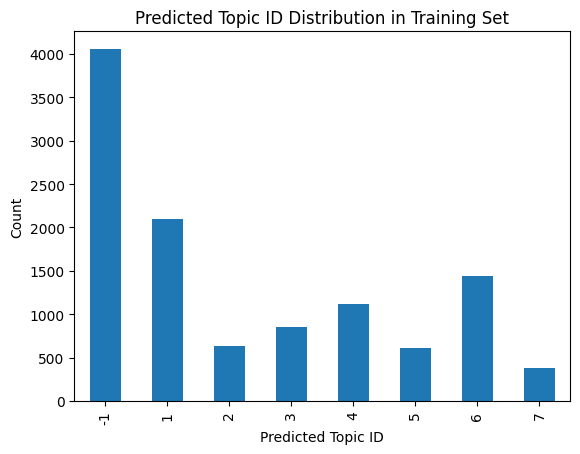

In [16]:
train_df.predicted_topic_id.value_counts().sort_index().plot(kind='bar', title='Predicted Topic ID Distribution in Training Set', xlabel='Predicted Topic ID', ylabel='Count')

Original samples: 11200
After removing outliers (Topic=-1): 7143
Outliers removed: 4057 (36.22%)

After removing unmapped predictions: 7143

[Saved] results\category_alignment\default_metrics.json


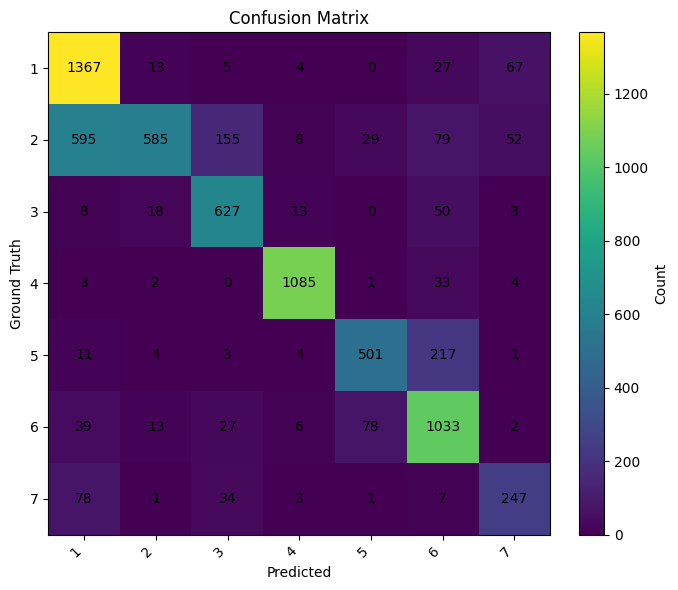

{'macro_f1': 0.7509911544315885,
 'weighted_f1': 0.748443185295925,
 'per_class_f1': [0.7628348214285714,
  0.5469845722300141,
  0.7987261146496816,
  0.964015992892048,
  0.7416728349370837,
  0.7813918305597579,
  0.6613119143239625],
 'labels': [1, 2, 3, 4, 5, 6, 7],
 'confusion_matrix': [[1367, 13, 5, 4, 0, 27, 67],
  [595, 585, 155, 8, 29, 79, 52],
  [8, 18, 627, 13, 0, 50, 3],
  [3, 2, 0, 1085, 1, 33, 4],
  [11, 4, 3, 4, 501, 217, 1],
  [39, 13, 27, 6, 78, 1033, 2],
  [78, 1, 34, 3, 1, 7, 247]]}

In [17]:
from Evaluations.category_alignment import compute_category_alignment

# Filter out outliers (Topic = -1) before evaluation
train_df_filtered = train_df[train_df["Topic"] != -1].copy()

print(f"Original samples: {len(train_df)}")
print(f"After removing outliers (Topic=-1): {len(train_df_filtered)}")
print(f"Outliers removed: {len(train_df) - len(train_df_filtered)} ({100*(len(train_df) - len(train_df_filtered))/len(train_df):.2f}%)")
print()

# Also filter out any predictions that are -1 (unmapped categories)
train_df_filtered = train_df_filtered[train_df_filtered["predicted_topic_id"] != -1].copy()
print(f"After removing unmapped predictions: {len(train_df_filtered)}")
print()

# Compute metrics on filtered data
compute_category_alignment(
    train_df_filtered["predicted_topic_id"].astype('int64'), 
    train_df_filtered["label"].astype('int64'), 
    plot_confusion=True
)

# Testing on test set

In [18]:
# load topic model and test embeddings 
docs = embeddings_test["text"].tolist()
embeddings_test = embeddings_test[[f"emb_{i}" for i in range(embeddings_test.shape[1]-2)]].to_numpy()

topics_test, probs_test = topic_model.transform(docs, embeddings_test)

2025-10-26 20:58:11,815 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-10-26 20:58:19,617 - BERTopic - Dimensionality - Completed ✓
2025-10-26 20:58:19,618 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-10-26 20:58:19,799 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-10-26 20:58:24,736 - BERTopic - Probabilities - Completed ✓
2025-10-26 20:58:24,736 - BERTopic - Cluster - Completed ✓


In [19]:
test_df["Topic"] = topics_test
test_df["Topic_Probability"] = [max(p) if p is not None else None for p in probs_test]
test_df

,text,label,embeddings,Topic,Topic_Probability
0,i am a little confused on all of the models of...,3,"[-0.09357894212007523, -0.009670869447290897, ...",-1,0.192514
1,im not familiar at all with the format of thes...,1,"[-0.07837387174367905, 0.008786062709987164, -...",-1,0.141579
2,turin turambar me department of utter misery w...,5,"[-0.019032955169677734, 0.06360289454460144, 0...",-1,0.462416
3,in article ilyess b bdira writes they were att...,6,"[0.02319703996181488, -0.017748475074768066, 0...",-1,0.366037
4,in article norman r paterson writes in article...,5,"[-0.03030451387166977, -0.039151500910520554, ...",2,0.272970
...,...,...,...,...,...
7425,henry spencer writes henry if i read you corre...,2,"[-0.03778072074055672, 0.005880619399249554, 0...",-1,0.360994
7426,in article paul nevai writes about them on act...,1,"[-0.0260704904794693, -0.0861431285738945, 0.0...",-1,0.912188
7427,i sent a version of this post out a while ago ...,4,"[0.09013141691684723, 0.06133661046624184, 0.0...",1,0.973298
7428,i have this kit which includes the following 1...,7,"[-0.0983097180724144, 0.09242033958435059, -0....",-1,0.188915


In [20]:
test_df = test_df.merge(labels_df[["Topic", "tuned_topic_name", "short_explanation"]], on="Topic", how="left")
test_df


,text,label,embeddings,Topic,Topic_Probability,tuned_topic_name,short_explanation
0,i am a little confused on all of the models of...,3,"[-0.09357894212007523, -0.009670869447290897, ...",-1,0.192514,NaN,NaN
1,im not familiar at all with the format of thes...,1,"[-0.07837387174367905, 0.008786062709987164, -...",-1,0.141579,NaN,NaN
2,turin turambar me department of utter misery w...,5,"[-0.019032955169677734, 0.06360289454460144, 0...",-1,0.462416,NaN,NaN
3,in article ilyess b bdira writes they were att...,6,"[0.02319703996181488, -0.017748475074768066, 0...",-1,0.366037,NaN,NaN
4,in article norman r paterson writes in article...,5,"[-0.03030451387166977, -0.039151500910520554, ...",2,0.272970,Religion,This cluster focuses on discussions about reli...
...,...,...,...,...,...,...,...
7425,henry spencer writes henry if i read you corre...,2,"[-0.03778072074055672, 0.005880619399249554, 0...",-1,0.360994,NaN,NaN
7426,in article paul nevai writes about them on act...,1,"[-0.0260704904794693, -0.0861431285738945, 0.0...",-1,0.912188,NaN,NaN
7427,i sent a version of this post out a while ago ...,4,"[0.09013141691684723, 0.06133661046624184, 0.0...",1,0.973298,Sports,This cluster covers news and reports related t...
7428,i have this kit which includes the following 1...,7,"[-0.0983097180724144, 0.09242033958435059, -0....",-1,0.188915,NaN,NaN


In [21]:
CATEGORY_NAME_TO_INT = {v: k for k, v in CATEGORY_NAME_MAP.items()}
test_df["predicted_topic_id"] = test_df["tuned_topic_name"].map(CATEGORY_NAME_TO_INT)
test_df["predicted_topic_id"] = test_df["predicted_topic_id"].fillna(-1).astype(int)
test_df

,text,label,embeddings,Topic,Topic_Probability,tuned_topic_name,short_explanation,predicted_topic_id
0,i am a little confused on all of the models of...,3,"[-0.09357894212007523, -0.009670869447290897, ...",-1,0.192514,NaN,NaN,-1
1,im not familiar at all with the format of thes...,1,"[-0.07837387174367905, 0.008786062709987164, -...",-1,0.141579,NaN,NaN,-1
2,turin turambar me department of utter misery w...,5,"[-0.019032955169677734, 0.06360289454460144, 0...",-1,0.462416,NaN,NaN,-1
3,in article ilyess b bdira writes they were att...,6,"[0.02319703996181488, -0.017748475074768066, 0...",-1,0.366037,NaN,NaN,-1
4,in article norman r paterson writes in article...,5,"[-0.03030451387166977, -0.039151500910520554, ...",2,0.272970,Religion,This cluster focuses on discussions about reli...,5
...,...,...,...,...,...,...,...,...
7425,henry spencer writes henry if i read you corre...,2,"[-0.03778072074055672, 0.005880619399249554, 0...",-1,0.360994,NaN,NaN,-1
7426,in article paul nevai writes about them on act...,1,"[-0.0260704904794693, -0.0861431285738945, 0.0...",-1,0.912188,NaN,NaN,-1
7427,i sent a version of this post out a while ago ...,4,"[0.09013141691684723, 0.06133661046624184, 0.0...",1,0.973298,Sports,This cluster covers news and reports related t...,4
7428,i have this kit which includes the following 1...,7,"[-0.0983097180724144, 0.09242033958435059, -0....",-1,0.188915,NaN,NaN,-1


Original samples: 7430
After removing outliers (Topic=-1): 3932
Outliers removed: 3498 (47.08%)

After removing unmapped predictions: 3932

[Saved] results\category_alignment\default_metrics.json


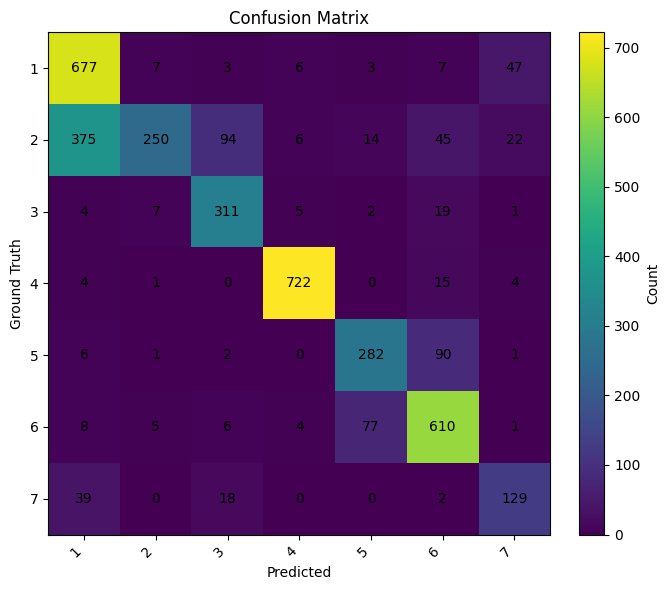

{'macro_f1': 0.7382380002065566,
 'weighted_f1': 0.7389469614681249,
 'per_class_f1': [0.726784755770263,
  0.46425255338904364,
  0.7943805874840357,
  0.9697783747481531,
  0.7421052631578947,
  0.8138759172781854,
  0.6564885496183206],
 'labels': [1, 2, 3, 4, 5, 6, 7],
 'confusion_matrix': [[677, 7, 3, 6, 3, 7, 47],
  [375, 250, 94, 6, 14, 45, 22],
  [4, 7, 311, 5, 2, 19, 1],
  [4, 1, 0, 722, 0, 15, 4],
  [6, 1, 2, 0, 282, 90, 1],
  [8, 5, 6, 4, 77, 610, 1],
  [39, 0, 18, 0, 0, 2, 129]]}

In [22]:
from Evaluations.category_alignment import compute_category_alignment

# Filter out outliers (Topic = -1) before evaluation
test_df_filtered = test_df[test_df["Topic"] != -1].copy()

print(f"Original samples: {len(test_df)}")
print(f"After removing outliers (Topic=-1): {len(test_df_filtered)}")
print(f"Outliers removed: {len(test_df) - len(test_df_filtered)} ({100*(len(test_df) - len(test_df_filtered))/len(test_df):.2f}%)")
print()

# Also filter out any predictions that are -1 (unmapped categories)
test_df_filtered = test_df_filtered[test_df_filtered["predicted_topic_id"] != -1].copy()
print(f"After removing unmapped predictions: {len(test_df_filtered)}")
print()

# Compute metrics on filtered data
compute_category_alignment(
    test_df_filtered["predicted_topic_id"].astype('int64'), 
    test_df_filtered["label"].astype('int64'), 
    plot_confusion=True
)